## hierachical teams

**Hierarchical Agent (계층적 에이전트)**는 복잡한 문제를 해결하기 위해 에이전트 간 계층 구조를 구성하는 개념입니다. 이 구조는 **큰 목표를 상위 에이전트가 하위 에이전트에게 분할 위임(delegation)**하고, 하위 에이전트는 세부 작업을 수행하는 방식으로 작동합니다.

               [Supervisor / Manager Agent]
                        |
        +---------------+------------------+
        |                                  |
 [Researcher Agent]                [Coder Agent]
        |                                  |
 [웹 검색 Tool]                    [Python 실행 Tool]

- 상위 에이전트: 전체 플로우를 조율하고, 어떤 하위 에이전트를 언제 호출할지를 판단합니다.
- 하위 에이전트: 특정 역할을 수행하는 Agent (예: 조사, 요약, 코딩, 문서화 등)

In [2]:
import dotenv
dotenv.load_dotenv()

True

## Create Tools

### 웹서치 툴 정의

In [3]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)

@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

### 다큐먼트 작성 툴 정의

In [4]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

## Helper Utilities

In [5]:
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Define Agent Teams

### research agent team

In [6]:
import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4o")

search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

research_agent = create_react_agent(llm, tools=[scrape_webpages])
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper"],
)

/var/folders/q5/zkf2r1390jl_wp2gxm05m0wc0000gn/T/ipykernel_20835/4061980305.py:48: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


In [7]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)


research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

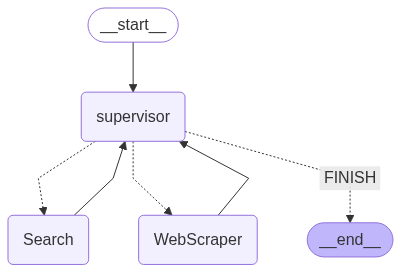

In [8]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [9]:
for s in research_chain.stream(
    "테일러 스위프트의 다음 투어 일정은 어떻게 돼?", {"recursion_limit": 10}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Search'}}
---
{'Search': {'messages': [HumanMessage(content='테일러 스위프트의 "The Eras Tour"는 2023년 8월 24일 멕시코시티에서 시작하여 2024년 11월 23일 캐나다 토론토에서 마무리됩니다. 그 투어는 국제적으로 펼쳐지며, 다음 주요 일정들을 포함합니다:\n\n- 2023년 11월 17일에서 20일까지는 리우데자네이루, 브라질.\n- 2023년 11월 24일에서 26일까지는 상파울루, 브라질.\n\n추가적으로, 그녀의 투어 일정은 다수의 다른 날짜와 장소에서 계속됩니다. [자세한 일정과 티켓 정보는 여기](https://www.nj.com/live-entertainment/2023/03/taylor-swift-tour-2023-full-schedule-dates-where-to-buy-tickets.html)에서 확인할 수 있습니다.', additional_kwargs={}, response_metadata={}, name='Search')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


### Document Writing Team

In [10]:
import operator
from pathlib import Path


# Document writing team graph state
class DocWritingState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    current_files: str


# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_react_agent(llm, tools=[write_document, edit_document, read_document])
# Injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_react_agent(llm,tools=[create_outline, read_document])
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

chart_generating_agent = create_react_agent(llm, tools=[read_document, python_repl])
context_aware_chart_generating_agent = prelude | chart_generating_agent
chart_generating_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="ChartGenerator"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

In [11]:
# Create the graph here:
# Note that we have unrolled the loop for the sake of this doc
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

# Add the edges that always occur
authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("ChartGenerator", "supervisor")

# Add the edges where routing applies
authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

authoring_graph.add_edge(START, "supervisor")
chain = authoring_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

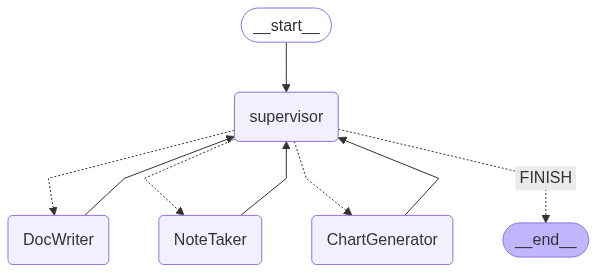

In [12]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [13]:
for s in authoring_chain.stream(
    "가을에 관한 시를 outline 작성한 후 그 시를 디스크에 작성하세요. 모든 작성은 한국어로 작성해주세요.",
    {"recursion_limit": 10},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'NoteTaker'}}
---
{'NoteTaker': {'messages': [HumanMessage(content='가을에 관한 시가 "가을_시.txt" 파일에 성공적으로 저장되었습니다. 이 파일은 가을의 풍경과 감성을 담고 있으며, 시를 통해 가을의 풍부한 음미를 느낄 수 있습니다.', additional_kwargs={}, response_metadata={}, name='NoteTaker')]}}
---
{'supervisor': {'next': 'NoteTaker'}}
---
{'NoteTaker': {'messages': [HumanMessage(content='"가을_시.txt" 파일에 시가 성공적으로 저장되었습니다. 사용한 아웃라인에 따라 가을의 다양한 측면을 포착한 시가 포함되어 있습니다. 이 파일을 통해 가을의 풍경과 감성을 만끽할 수 있습니다.', additional_kwargs={}, response_metadata={}, name='NoteTaker')]}}
---
{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='"가을_시.txt" 파일에 가을에 관한 시가 성공적으로 저장되었습니다. 이 시는 가을의 다양한 풍경과 감성을 담아낸 작품으로, 가을의 아름다움과 쓸쓸함을 동시에 느낄 수 있도록 구성되었습니다.', additional_kwargs={}, response_metadata={}, name='DocWriter')]}}
---
{'supervisor': {'next': 'NoteTaker'}}
---
{'NoteTaker': {'messages': [HumanMessage(content='"가을_시.txt" 파일에 가을에 관한 시가 성공적으로 작성되었습니다. 이 시는 가을의 다채로운 풍경과 감정을 담고 있으며, 계절의 변화, 단풍의 아름다움, 쌀쌀한 바람, 낙엽이 지는 모습, 

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

## Add Layers

탑다운 방식의 라우팅으로 두 그래프간의 작업을 어떻게 라우팅할지 정의


In [16]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam"],
)

In [17]:
# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "PaperWritingTeam", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("ResearchTeam", "supervisor")
super_graph.add_edge("PaperWritingTeam", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()

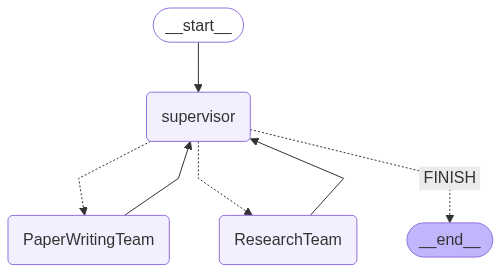

In [18]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [19]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="차트를 포함한 사막여우에 대한 간단한 리포트를 한국어로 작성해줘."
            )
        ],
    },
    {"recursion_limit": 20},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'ResearchTeam'}}
---
{'ResearchTeam': {'messages': [HumanMessage(content='사막여우(페넥여우)는 그 독특하고 사랑스러운 외모로 많은 사람들의 주목을 받고 있으며, 아프리카의 사하라 사막을 중심으로 하는 사막 지역에서 주로 발견됩니다. 이들은 척박한 환경에 잘 적응해 살고 있는 야생 동물로, 다음과 같은 특징을 지니고 있습니다.\n\n### 신체적 특징\n- **크기**: 사막여우의 몸 길이는 약 36cm이며, 꼬리는 23~25cm 정도입니다. 평균 체중은 약 1.3kg로 작은 편입니다.\n- **귀**: 큰 귀는 사막여우의 가장 두드러진 특징 중 하나로, 열을 발산하는 데 효과적이며 사냥이나 포식자를 감지하는 데 도움을 줍니다.\n- **털**: 짧은 털은 사막의 극심한 온도 차이에도 체온을 효과적으로 조절할 수 있도록 돕습니다.\n\n### 서식지 및 생활 방식\n- 사막여우는 주로 **북아프리카 사하라 사막** 내의 모래 언덕과 바위 지역에 서식하며, 이러한 지형에 맞게 튼튼한 발톱을 통해 굴을 파고 빠르게 이동할 수 있습니다.\n- 주로 야행성으로 활동하며, 새벽이나 저녁에 먹이를 찾아 나섭니다.\n\n### 보전 상태\n- IUCN에 따르면, 사막여우는 **‘관심 필요’(Least Concern)** 등급으로 멸종 위험이 낮은 편입니다.\n- 그러나 **CITES 부속서 II**에 등록되어 있어 국제적인 거래에 대한 규제가 이루어지고 있으며, 이는 불법 포획과 모피 산업으로 인한 위협을 방지하기 위함입니다.\n\n### 애완동물로서의 주의사항\n사막여우는 특이한 외모 덕에 애완동물로서 관심을 받고 있지만, 이들의 자연 습성과 요구 사항을 이해하지 못한 채 기르는 것은 바람직하지 않습니다. 이들은 넓은 공간이 필요하며, 특수한 식단과 환경 조건이 필요하므로 충분한 지식과 책임을 가지고 접근해야 합니다.\n\n사막여우는 주로 그 환경에 적응하여 그들만의 방식

GraphRecursionError: Recursion limit of 20 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT